In [11]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [12]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from final.feature_extraction.clean_text import *
from final.feature_encoding.one_hot_encoding import one_hot_encode_feature
from final.feature_extraction.extract_text_info import extract_general_row_info, extract_row_word_counts
from final.model_evaluation.classification_model_evaluation import train_classification_model
from final.model_evaluation.visualizations import visualize_model_feature_importances, visualize_2d_cluster_with_legend


In [13]:
df = pd.read_csv("../../data/random_samples/stratified_sampling_data_by_price_whigh_sz50000_1619218354.csv")
df.shape

(50000, 11)

In [14]:
df.head(3)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c1,c2,c3,price_bin
0,694996,Lululemon Wunder Under w/ stirrup- BLACK,2,Lululemon,84.0,0,All black. Size 4,women,athletic apparel,"pants, tights, leggings","(80, 90]"
1,1005043,iPhone 7 Plus - 128 GB - Silver/Unlocked,1,Apple,739.0,0,"Brand new Apple iPhone 7 Plus , 128 GB, in the...",electronics,cell phones & accessories,cell phones & smartphones,"(500, 2500]"
2,1379656,4moms rockaroo,3,mamaRoo,75.0,0,4moms swing rockaroo Used for babies from birt...,kids,gear,"swings, jumpers & bouncers","(70, 80]"


# Encode Price Bin

In [15]:
encode_df, encode_col = one_hot_encode_feature(df, encode_column='price_bin',drop_first=False)
encode_df.shape

(50000, 26)

In [16]:
encode_df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c1,c2,c3,...,"price_bin_(25, 30]","price_bin_(30, 40]","price_bin_(40, 50]","price_bin_(5, 10]","price_bin_(50, 60]","price_bin_(500, 2500]","price_bin_(60, 70]","price_bin_(70, 80]","price_bin_(80, 90]","price_bin_(90, 100]"
0,694996,Lululemon Wunder Under w/ stirrup- BLACK,2,Lululemon,84.0,0,All black. Size 4,women,athletic apparel,"pants, tights, leggings",...,0,0,0,0,0,0,0,0,1,0
1,1005043,iPhone 7 Plus - 128 GB - Silver/Unlocked,1,Apple,739.0,0,"Brand new Apple iPhone 7 Plus , 128 GB, in the...",electronics,cell phones & accessories,cell phones & smartphones,...,0,0,0,0,0,1,0,0,0,0
2,1379656,4moms rockaroo,3,mamaRoo,75.0,0,4moms swing rockaroo Used for babies from birt...,kids,gear,"swings, jumpers & bouncers",...,0,0,0,0,0,0,0,1,0,0
3,674670,Nivea Lip Balm,1,Nivea,16.0,1,(10) Nivea Lip As pictured New Price is for al...,other,daily & travel items,personal care,...,0,0,0,0,0,0,0,0,0,0
4,1439218,Louis Vuitton neverfull MM,2,Louis Vuitton,704.0,0,Size:MM,women,women's handbags,shoulder bag,...,0,0,0,0,0,1,0,0,0,0


In [17]:
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   train_id               50000 non-null  int64  
 1   name                   50000 non-null  object 
 2   item_condition_id      50000 non-null  int64  
 3   brand_name             50000 non-null  object 
 4   price                  50000 non-null  float64
 5   shipping               50000 non-null  int64  
 6   item_description       50000 non-null  object 
 7   c1                     50000 non-null  object 
 8   c2                     50000 non-null  object 
 9   c3                     50000 non-null  object 
 10  price_bin_(0, 5]       50000 non-null  uint8  
 11  price_bin_(10, 15]     50000 non-null  uint8  
 12  price_bin_(100, 200]   50000 non-null  uint8  
 13  price_bin_(15, 20]     50000 non-null  uint8  
 14  price_bin_(20, 25]     50000 non-null  uint8  
 15  pr

# Extract Item Name Features

In [18]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
num_of_processes  = 8
col_name = 'name'
clean_col_name = "clean_%s" % col_name

df = parallelize(encode_df, partial(extract_counts, col_name=col_name, prefix="bef"), num_of_processes)
df = parallelize(encode_df, partial(extract_info, col_name=col_name, stop_words=stop_words), num_of_processes)

progress-bar: 100%|██████████| 6250/6250 [00:40<00:00, 154.86it/s]

progress-bar: 100%|██████████| 6250/6250 [01:09<00:00, 90.54it/s]


# Split Train Test

In [19]:
X = df.select_dtypes(include=['int64']).drop(columns=list(encode_col)+['train_id'])
x_col = X.columns
X['name'] = df['name']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_condition_id  50000 non-null  int64 
 1   shipping           50000 non-null  int64 
 2   upper_word_count   50000 non-null  int64 
 3   upper_char_count   50000 non-null  int64 
 4   stopword_count     50000 non-null  int64 
 5   punctuation_count  50000 non-null  int64 
 6   number_count       50000 non-null  int64 
 7   name               50000 non-null  object
dtypes: int64(7), object(1)
memory usage: 3.1+ MB


In [20]:
y = encode_df[encode_col]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   price_bin_(0, 5]       50000 non-null  uint8
 1   price_bin_(10, 15]     50000 non-null  uint8
 2   price_bin_(100, 200]   50000 non-null  uint8
 3   price_bin_(15, 20]     50000 non-null  uint8
 4   price_bin_(20, 25]     50000 non-null  uint8
 5   price_bin_(200, 500]   50000 non-null  uint8
 6   price_bin_(25, 30]     50000 non-null  uint8
 7   price_bin_(30, 40]     50000 non-null  uint8
 8   price_bin_(40, 50]     50000 non-null  uint8
 9   price_bin_(5, 10]      50000 non-null  uint8
 10  price_bin_(50, 60]     50000 non-null  uint8
 11  price_bin_(500, 2500]  50000 non-null  uint8
 12  price_bin_(60, 70]     50000 non-null  uint8
 13  price_bin_(70, 80]     50000 non-null  uint8
 14  price_bin_(80, 90]     50000 non-null  uint8
 15  price_bin_(90, 100]    50000 non-nul

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, 
                                                    test_size=0.30, random_state=42, stratify = y)

# Vectorization of Item Name

In [22]:
num_features = 20
tv = TfidfVectorizer(max_features=num_features)
train_name_feature = tv.fit_transform(X_train.name.to_list())

train_name_feature.toarray().shape

(35000, 20)

In [23]:
X_train = np.concatenate((train_name_feature.toarray(), X_train[x_col].values),axis=1)
X_test = np.concatenate((tv.transform(X_test.name.to_list()).toarray(), X_test[x_col].values),axis=1)

In [24]:
names = tv.get_feature_names()
names

['and',
 'bag',
 'black',
 'bundle',
 'for',
 'iphone',
 'kors',
 'louis',
 'lularoe',
 'lululemon',
 'michael',
 'new',
 'nike',
 'nwt',
 'pink',
 'secret',
 'size',
 'victoria',
 'vs',
 'vuitton']

In [25]:
x_tf_names = ['tf%02d_%s'%(i,names[i-1]) for i in range(1, num_features+1)]
x_tf_names += list(x_col)

# Classification - Random Forest

In [26]:
rf_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(RandomForestClassifier(n_estimators=50), 
                                                              X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.45677142857142855

Top 5 class with highest train accuracy
price_bin_(0, 5]     - 0.82984
price_bin_(500, 2500] - 0.77448
price_bin_(200, 500] - 0.47947
price_bin_(25, 30]   - 0.44526
price_bin_(30, 40]   - 0.43431

Top 5 class with lowest train accuracy
price_bin_(5, 10]    - 0.36086
price_bin_(20, 25]   - 0.36832
price_bin_(40, 50]   - 0.36924
price_bin_(15, 20]   - 0.38139
price_bin_(50, 60]   - 0.38321
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.1562

Top 5 class with highest test accuracy
price_bin_(500, 2500] - 0.69374
price_bin_(0, 5]     - 0.64004
price_bin_(200, 500] - 0.18317
price_bin_(10, 15]   - 0.10756
price_bin_(100, 200] - 0.10745

Top 5 class with lowest test accuracy
price_bin_(40, 50]   - 0.05426
price_bin_(60, 70]   - 0.05426
price_bin_(50, 60]   - 0.05538
price_bin_(20, 25]   - 0.06064
price_bin_(80, 90]   - 0.07135


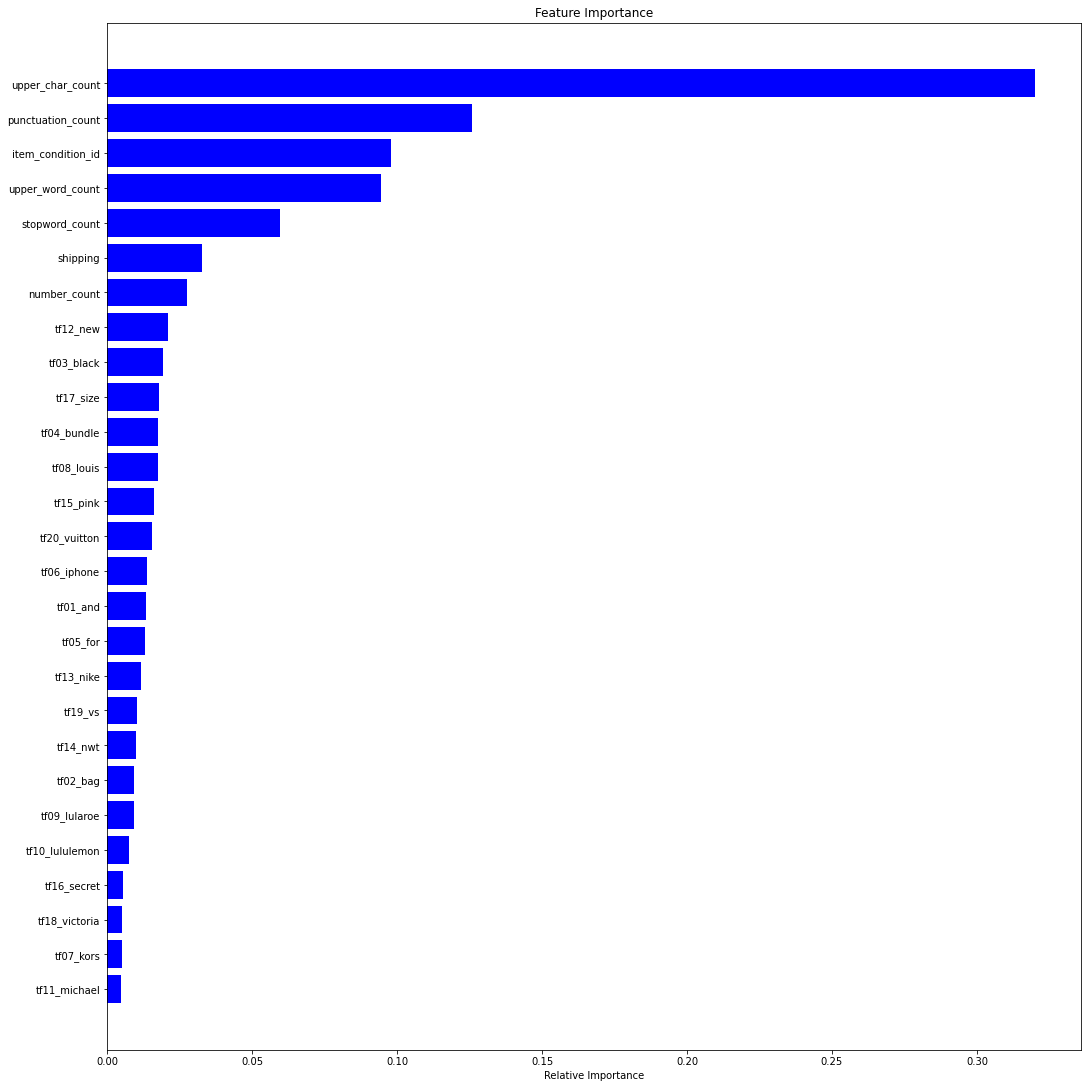

In [50]:
feature_importances = visualize_model_feature_importances(rf_model, x_tf_names, title = "Feature Importance")

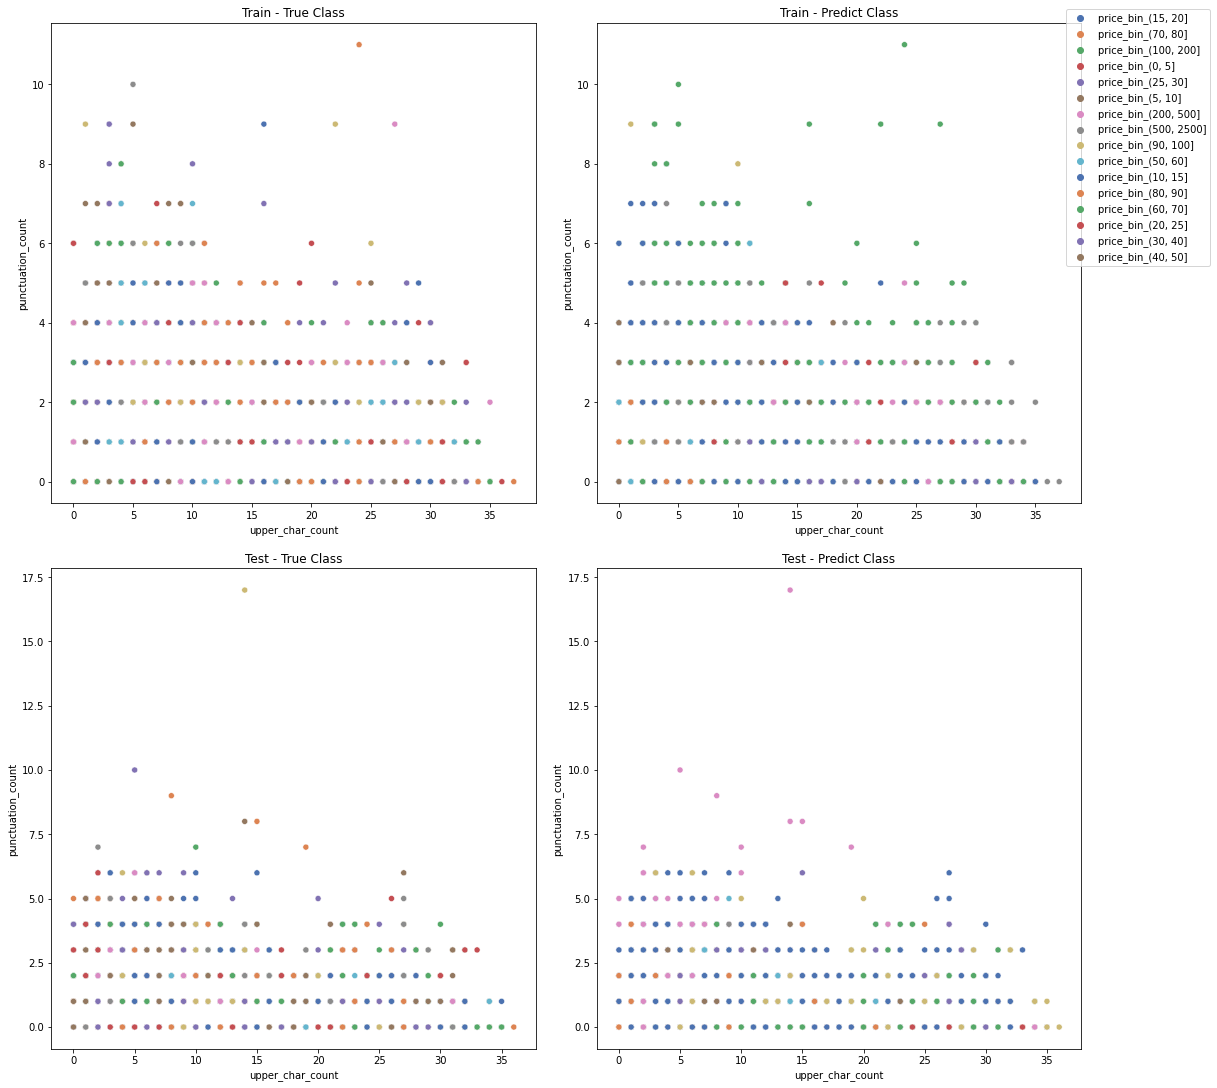

In [53]:
visualize_2d_cluster_with_legend('price_bin', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred)

# Classification - Logistic Regression

In [29]:
lr_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(LogisticRegression(max_iter=500), 
                                                             X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.1619142857142857

Top 5 class with highest train accuracy
price_bin_(0, 5]     - 0.87865
price_bin_(500, 2500] - 0.38277
price_bin_(200, 500] - 0.24772
price_bin_(10, 15]   - 0.17518
price_bin_(100, 200] - 0.16066

Top 5 class with lowest train accuracy
price_bin_(40, 50]   - 0.01050
price_bin_(50, 60]   - 0.02418
price_bin_(20, 25]   - 0.03971
price_bin_(5, 10]    - 0.04425
price_bin_(25, 30]   - 0.06797
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.15566666666666668

Top 5 class with highest test accuracy
price_bin_(0, 5]     - 0.87327
price_bin_(500, 2500] - 0.36114
price_bin_(200, 500] - 0.24494
price_bin_(10, 15]   - 0.16720
price_bin_(15, 20]   - 0.14271

Top 5 class with lowest test accuracy
price_bin_(40, 50]   - 0.01277
price_bin_(50, 60]   - 0.03195
price_bin_(20, 25]   - 0.03936
price_bin_(5, 10]    - 0.04686
price_bin_(25, 30]   - 0.05857


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


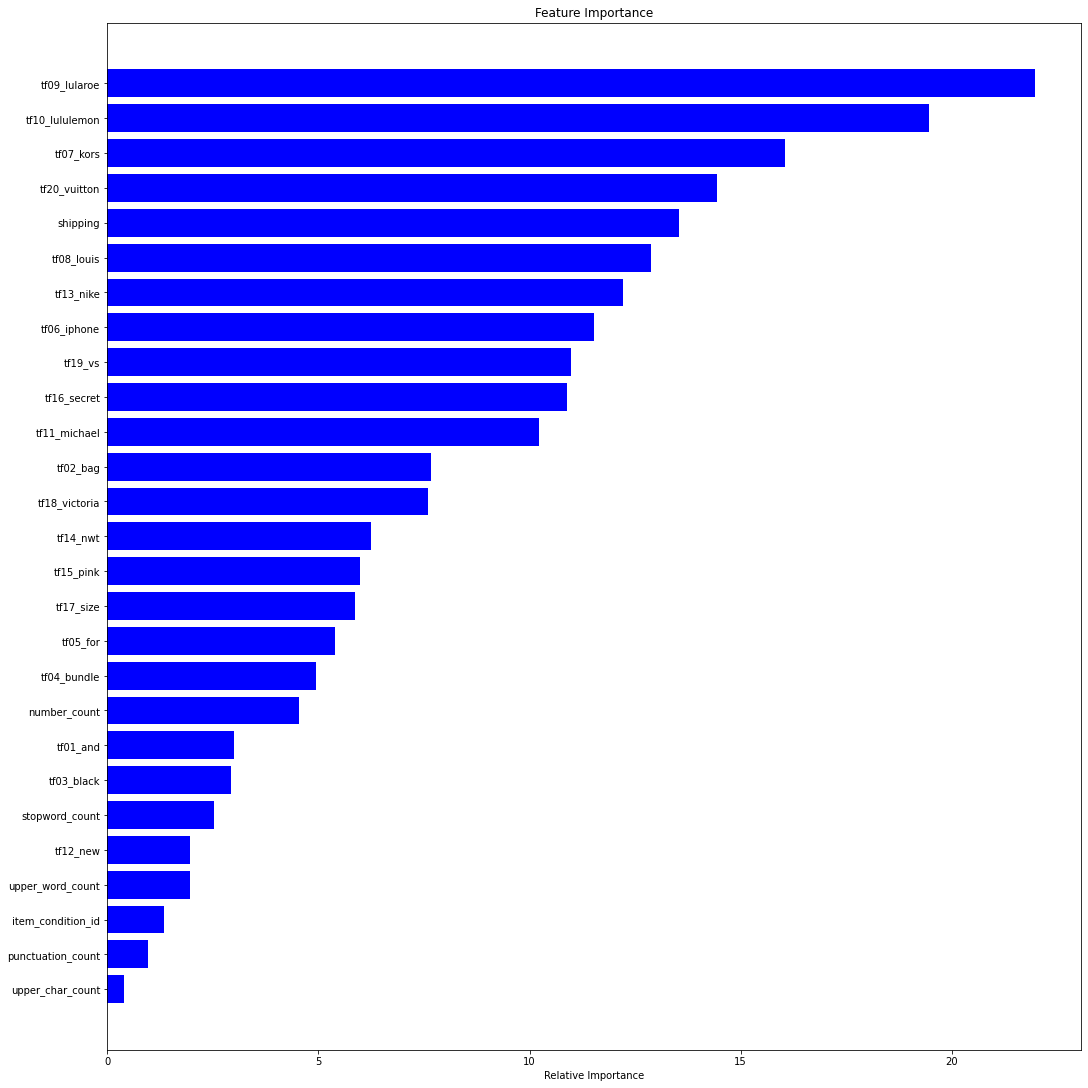

In [54]:
feature_importances = visualize_model_feature_importances(lr_model, x_tf_names, title = "Feature Importance")

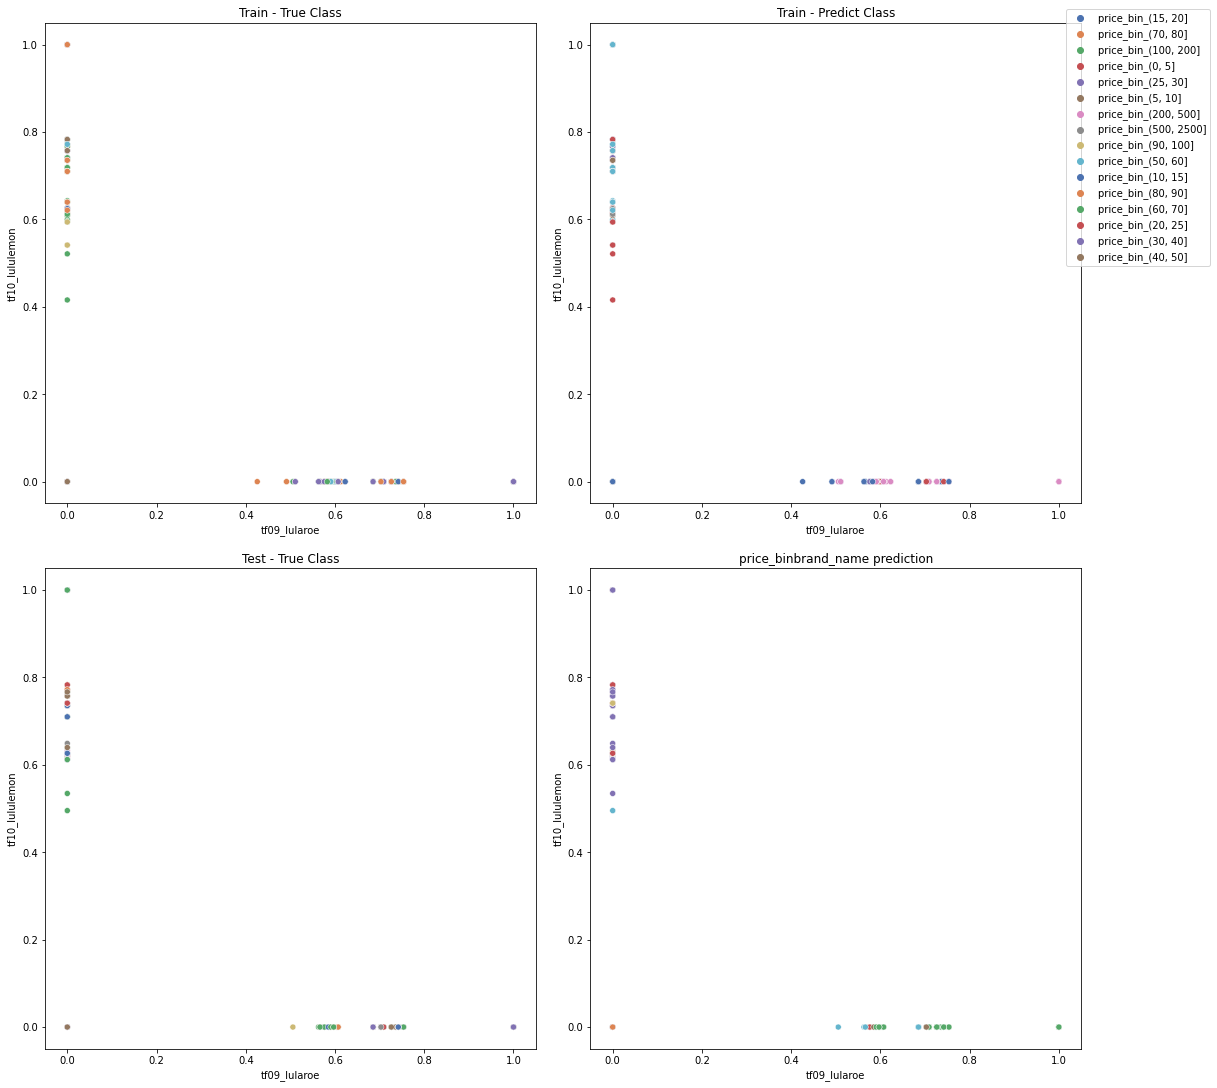

In [55]:
visualize_2d_cluster_with_legend('price_bin', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred,
                                legend = True, title = "price_binbrand_name prediction")